# Link sparsification

Utility results, latest update (Sep. 3, 2025) for matplotlib in python3.10 and font setup for IEEE publication (IEEE TWC final)

In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
import scipy.io as sio

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from IPython.display import Video

import pickle


### Install latex for IEEE journal acceptable fonts
Also install poppler for inspecting fonts in PDF

```bash
apt-get update
apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-fonts-extra dvipng ghostscript cm-super
sudo apt install -y poppler-utils
```

In [3]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "ps.fonttype": 42,      # embed TrueType in EPS
    "pdf.fonttype": 42,
    "savefig.transparent": False,  # no page transparency (EPS can't do alpha)
    "legend.framealpha": 1.0,      # if you use legends, make them opaque
})

### Function to create a graph from a 2D Piosson Point process  
Strictly speaking, the number of nodes should be generated from a Poisson process

```python
N = np.random.poisson(lam=area*density)
```

In [11]:
def poisson_graphs(area, N, rc=1.0, ri=2.0, dist='uniform', maxWts=1.0):
    lenth_a = np.sqrt(area)
    xys = np.random.uniform(0, lenth_a, (N, 2))
    d_mtx = distance_matrix(xys, xys)

    # generate connectivity graph
    adj_c = np.zeros([N,N], dtype=int)
    adj_c[d_mtx <= rc] = 1
    np.fill_diagonal(adj_c, 0)
    # graph_c = nx.from_numpy_matrix(adj_c)
    graph_c = nx.from_numpy_array(adj_c)
    for u in graph_c:
        graph_c.nodes[u]['xy'] = xys[u, :]

    # generate interference graph
    adj_i = np.zeros([N,N], dtype=int)
    adj_i[d_mtx <= ri] = 1
    np.fill_diagonal(adj_i, 0)
    # graph_i = nx.from_numpy_matrix(adj_i)

    # generate conflict graph
    graph_cf = nx.Graph()
    i = 0
    for e in graph_c.edges:
        graph_cf.add_node(i, weight=1.0, name=e)
        i += 1
    for u in graph_cf:
        nu = graph_cf.nodes[u]['name']
        for v in graph_cf:
            if u == v:
                continue
            nv = graph_cf.nodes[v]['name']
            if adj_i[nu[0], nv[0]] + adj_i[nu[0], nv[1]] + adj_i[nu[1], nv[0]] + adj_i[nu[1], nv[1]]:
                graph_cf.add_edge(u, v)

    # adj = nx.to_numpy_matrix(graph_cf)
    adj = nx.to_numpy_array(graph_cf)
    gdict = {'adj_c': adj_c, 'adj_i': adj, 'd_mtx': d_mtx, 'xys': xys}

    return graph_c, graph_cf, gdict



### Simulate Poisson graph with x=1.2 (interference to connectivity ratio)

In [15]:
sim_area = 36
sim_node = 300
sim_rc = 0.5
sim_ri = 0.6

### Fig. 2(a) visualize a 2D Poisson graph 

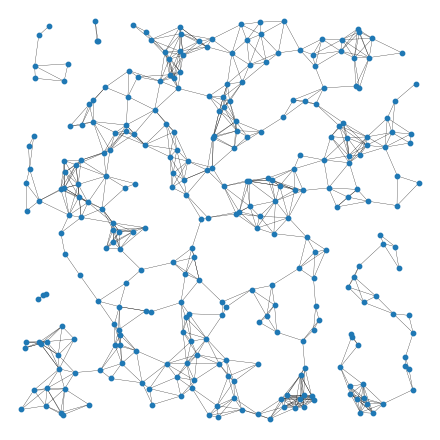

In [13]:
# graph_c, graph_i, gdict = xy_graphs(X, rc=sim_rc, ri=sim_ri)
graph_c, graph_i, gdict = poisson_graphs(sim_area, sim_node, rc=sim_rc, ri=sim_ri)

fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph_c, 'xy')
nx.draw(graph_c, ax=ax, pos=pos, node_size=10, width=0.2)
ax.margins(-0.02)

fname= os.path.join('./output/', 'example_network_2D_spatial')
fname = fname + '.pdf'
fig.set_size_inches(4.5, 4.5)
plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')


In [17]:
degrees = np.array([])
for i in range(100):
    graph_c, graph_i, gdict = poisson_graphs(sim_area, sim_node, rc=sim_rc, ri=sim_ri)
    degrees_i = gdict['adj_i'].sum(0)
    degrees_i = np.array(degrees_i).flatten()
    degrees = np.concatenate([degrees, degrees_i])

91366


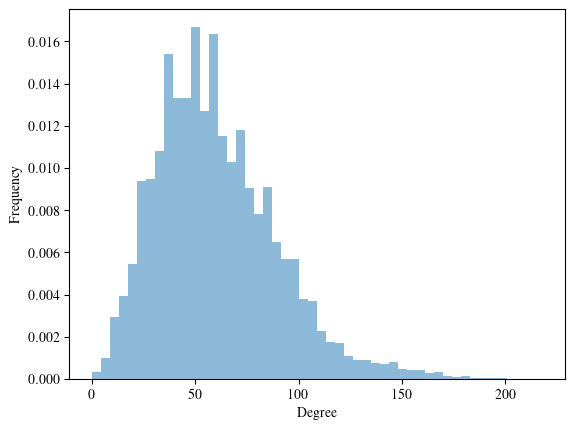

In [18]:
# degrees = gdict['adj_i'].sum(0)
# degrees = np.array(degrees).flatten()
degree_count = len(degrees)
print(degree_count)
fig, ax = plt.subplots()
ax.hist(degrees, bins=50, density=True, alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
plt.show()

In [19]:
# degrees_2d_U300x1 = degrees_2d_uniform
degrees_2d_uniform = degrees
# csv_name='./data/node_degree_2D_200nodes_x1.csv'
csv_name='./data/node_degree_2D_300nodes_x1.2.csv'
np.savetxt(csv_name, degrees_2d_uniform, delimiter=',')

### Simulate 2D Poisson graph with x=2.0

In [20]:
sim_ri = 1.0

degrees = np.array([])
for i in range(100):
    graph_c, graph_i, gdict = poisson_graphs(sim_area, sim_node, rc=sim_rc, ri=sim_ri)
    degrees_i = gdict['adj_i'].sum(0)
    degrees_i = np.array(degrees_i).flatten()
    degrees = np.concatenate([degrees, degrees_i])

degrees_2d_x2 = degrees

90938


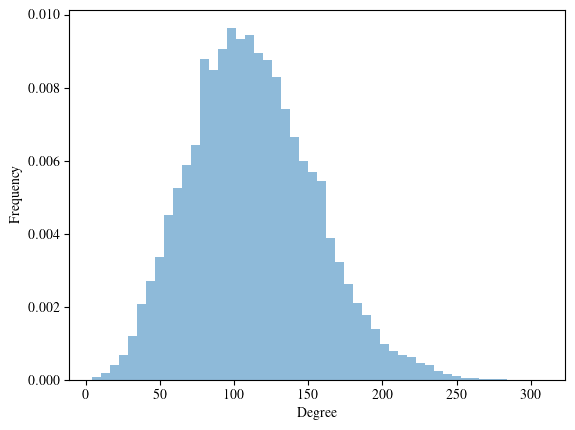

In [21]:
degree_count = len(degrees)
print(degree_count)
fig, ax = plt.subplots()
ax.hist(degrees, bins=50, density=True, alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
plt.show()

### Simulate ER graphs

In [22]:
degrees_er = np.array([])
for i in range(500):
    n_nodes = np.random.uniform(200, 400)
    N_p = np.random.normal(100,30)
    p_edges = N_p/n_nodes
    g = nx.erdos_renyi_graph(n=int(n_nodes), p=p_edges)
    adj_i = nx.to_scipy_sparse_array(g)
    degrees_i = adj_i.sum(0)
    degrees_i = np.array(degrees_i).flatten()
    degrees_er = np.concatenate([degrees_er, degrees_i])


147015


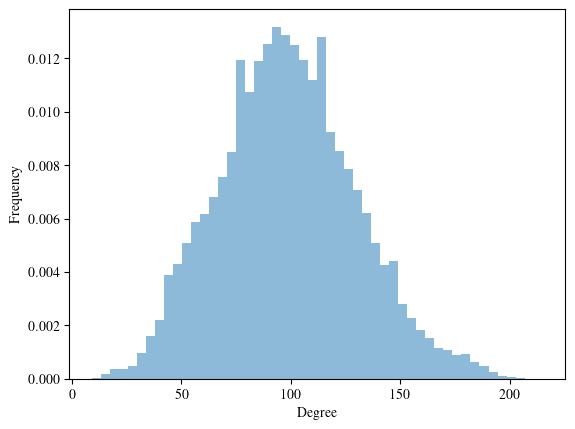

In [23]:
degree_count = len(degrees_er)
print(degree_count)
fig, ax = plt.subplots()
ax.hist(degrees_er, bins=50, density=True, alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
plt.show()

### Summarize degree distribution of BA graphs

```python
datapath = './data/BA_Graph_Uniform_GEN24_test2'
degrees_ba = np.array([])
mat_names = sorted(os.listdir(datapath))

for idx in range(len(mat_names)):
    mat_contents = sio.loadmat(os.path.join(datapath, mat_names[idx]))
    adj_0 = mat_contents['adj'].todense()
    degrees_i = adj_0.sum(0)
    degrees_i = np.array(degrees_i).flatten()
    degrees_ba = np.concatenate([degrees_ba, degrees_i])

print(degrees_ba.size)
csv_name='./data/node_degree_BA_Uniform_GEN24_test2.csv'
np.savetxt(csv_name, degrees_ba, delimiter=',')
```

### Plot Fig. 2(b)

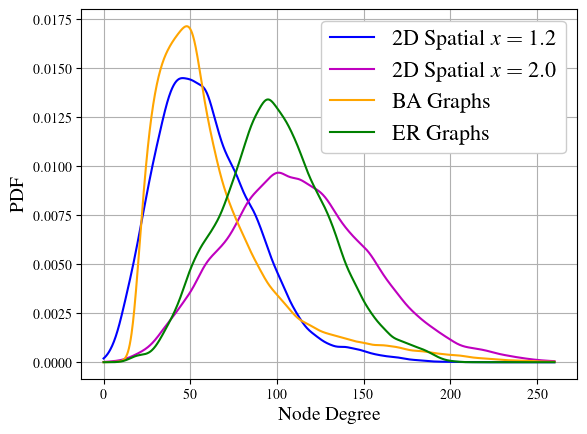

<Figure size 640x480 with 0 Axes>

In [25]:
degrees_ba = np.loadtxt('./data/node_degree_BA_Uniform_GEN24_test2.csv', delimiter=',')
pdf_2d = gaussian_kde(degrees_2d_uniform)
pdf_er = gaussian_kde(degrees_er)
pdf_ba = gaussian_kde(degrees_ba)
pdf_2dx2 = gaussian_kde(degrees_2d_x2)

x_min, x_max = 0, 260
step = 3

x = np.linspace(x_min, x_max, 1000)
bins = np.arange(x_min, x_max+step, step)

fig, ax = plt.subplots()
ax.plot(x, pdf_2d(x), label='2D Spatial $x=1.2$', color='b')
ax.plot(x, pdf_2dx2(x), label='2D Spatial $x=2.0$', color='m')
ax.plot(x, pdf_ba(x), label='BA Graphs', color='orange')
ax.plot(x, pdf_er(x), label='ER Graphs', color='g')
# ax.hist(degrees_2d_uniform, bins=bins, density=True, color='b', alpha=0.5, label='2D Spatial x1 hist')
# ax.hist(degrees_2d_x2, bins=bins, density=True, color='m', alpha=0.5, label='2D Spatial x2 hist')
# ax.hist(degrees_ba, bins=bins, density=True, color='orange', alpha=0.5, label='BA Graphs hist')
# ax.hist(degrees_er, bins=bins, density=True, color='g', alpha=0.5, label='ER Graphs hist')

ax.legend(fontsize=16)
ax.set_xlabel('Node Degree', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
ax.grid(True)
plt.show()

fontsize = 14
for axitem in ([ax.title] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    axitem.set_fontsize(fontsize)

fname= os.path.join('./output/', 'node_degree_pdfs')
fname = fname + '.pdf'
fig.set_size_inches(6, 4.5)
plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')
fig.savefig(fname.replace('.pdf','.eps'), 
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            pad_inches=0.01,
            bbox_inches='tight',
            format='eps')

### Visualization of other types of random graphs

In [6]:
pos = nx.spring_layout(graph)

In [36]:
try:
    graph = nx.random_powerlaw_tree(50, gamma=3.0, seed=0, tries=100000)
except:
    graph = nx.random_powerlaw_tree(50, gamma=3.0, tries=100000)

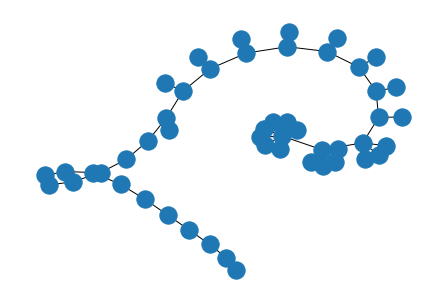

In [37]:
nx.draw_spring(graph)

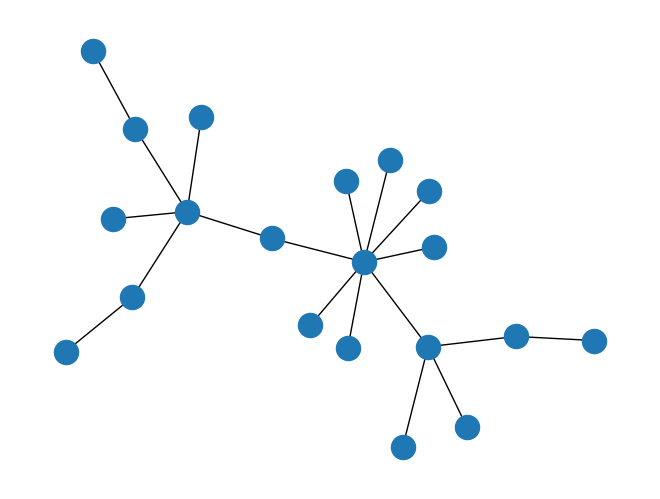

In [4]:
graph = nx.generators.random_graphs.barabasi_albert_graph(20, 1)
nx.draw_kamada_kawai(graph)

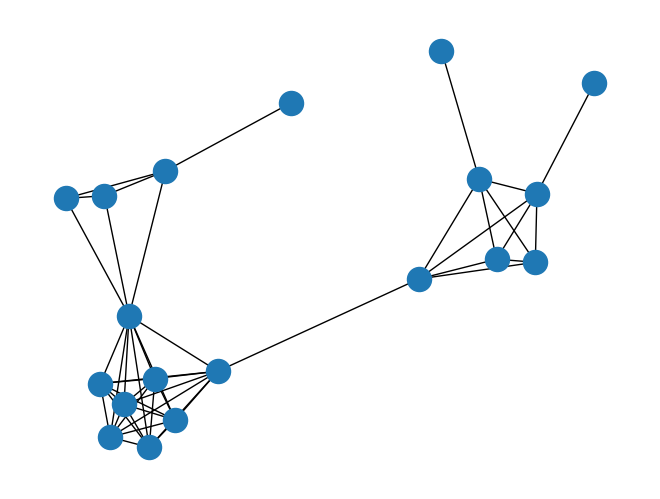

In [5]:
lg = nx.line_graph(graph)
nx.draw_spring(lg)

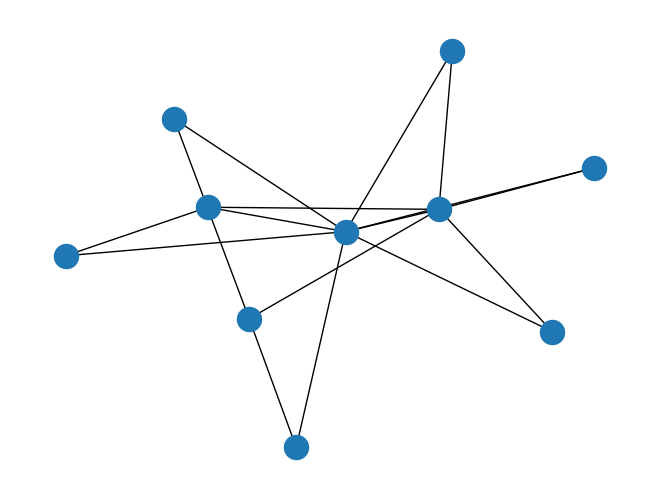

In [6]:
graph = nx.generators.random_graphs.barabasi_albert_graph(10, 2)
# nx.draw_kamada_kawai(graph)
nx.draw_spring(graph)

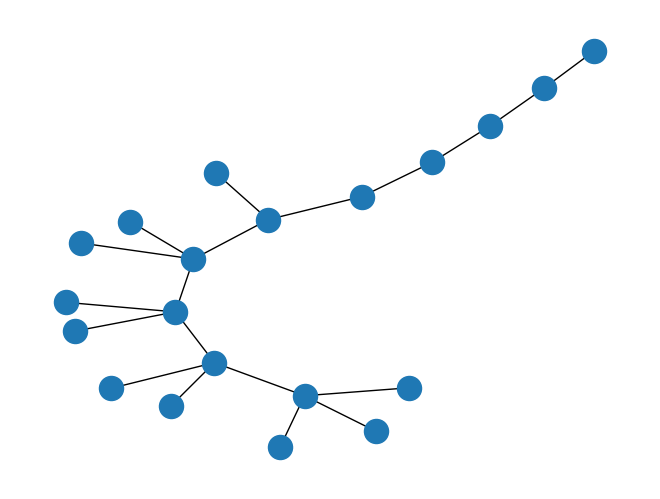

In [7]:
graph = nx.random_powerlaw_tree(20, gamma=3.0, tries=1000)
nx.draw_kamada_kawai(graph)

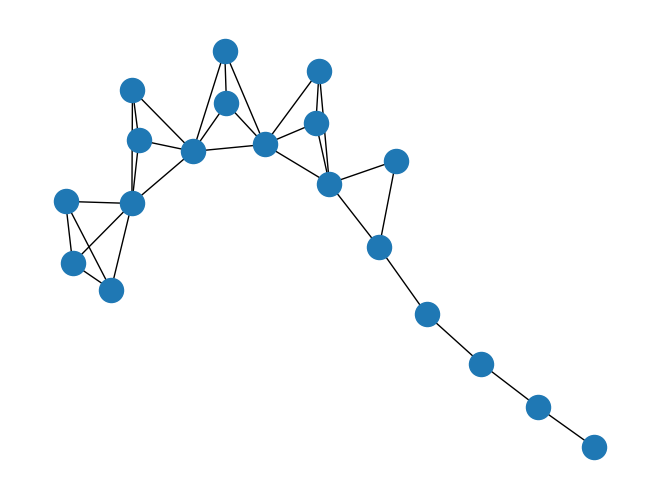

In [8]:
lg = nx.line_graph(graph)
nx.draw_kamada_kawai(lg)

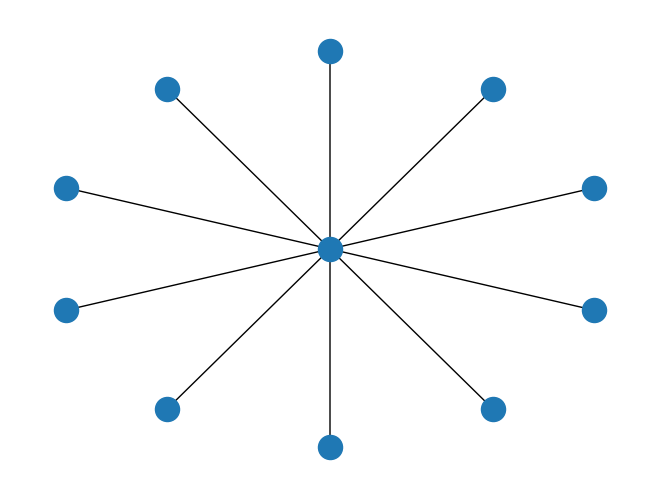

In [9]:
nx.draw_kamada_kawai(nx.star_graph(10))

In [160]:
# Define the parameters of the Gaussian mixture process
lambda_ = 2.0  # Intensity parameter of the Poisson point process
n_components = np.random.poisson(lambda_)

# Generate random points from the Poisson point process
points = np.random.uniform(size=(n_components, 2))*6

n_samples = 200  # Number of samples to generate
# means = np.array([[0, 0], [3, 3], [-3, 3]])  # Mean vectors of the Gaussian components
# covs = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])  # Covariance matrices of the Gaussian components
# weights = np.array([0.5, 0.3, 0.2])  # Weights of the Gaussian components
means = points  # Mean vectors of the Gaussian components
covs = np.array([[[1, 0], [0, 1]]]*n_components)
weights = np.random.uniform(0,1,n_components) 
weights = np.power(weights,2)

# Generate samples from the Gaussian mixture process
gmm = GaussianMixture(n_components=n_components, 
                      covariance_type='full')

gmm.weights_ = weights / weights.sum()
gmm.means_ = means
gmm.covariances_ = covs

# gmm.fit(X=np.random.randn(n_samples, 2))

X = gmm.sample(n_samples)[0]

In [161]:
print(X.shape)
print(n_components)
print(points)

(200, 2)
3
[[1.76307536 0.48296313]
 [4.48774687 5.22549474]
 [2.62353158 1.0523318 ]]


In [ ]:
# Estimate the PDF from the samples using a Gaussian kernel density estimator
kde = gaussian_kde(X.T)

# Create a grid of points at which to evaluate the PDF
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid_coords = np.vstack((xx.ravel(), yy.ravel()))

# Evaluate the PDF at the grid points and reshape the result into a 2D array
pdf = kde(grid_coords).reshape(xx.shape)
pdf = np.swapaxes(pdf, 0, 1)

# Visualize the samples and the PDF on a 2D plane
fig, ax = plt.subplots(figsize=(8,8))
# ax.scatter(X[:, 0], X[:, 1], alpha=0.2, color='blue')
ax.scatter(X[:, 0], X[:, 1], alpha=0.2, color='blue')
ax.imshow(pdf, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

# # Visualize the samples on a 2D plane
# plt.figure(figsize=(8, 8)) 
# plt.scatter(X[:, 0], X[:, 1])
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.show()